In [55]:
import pickle, os, glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize

In [56]:
path = "D:/data/SiPM/waveforms/20240521/am241"
filename_list = ["Am241_28V_x0.0_y0.0_*.pkl",] 
save_str = ["Am241",]
ov_list = [28,]
data_time = [100, ] ## acquisition time in seconds

In [57]:
ovs_dict = {}

fsample = 62.5e6 ## sampling rate in Hz
record_length = 129 ## not clear why this differs from the 128 set above
time_vec = np.arange(0, record_length/fsample, 1/fsample)

for j,filename in enumerate(filename_list):
    
    curr_files = glob.glob(os.path.join(path, filename))
    
    data_dict = {}

    wfidx = 0
    for cidx, cf in enumerate(curr_files):
        
        with open(cf, 'rb') as fin:
            curr_dict = pickle.load(fin)

            for wf in curr_dict:

                sum_waveform = np.zeros_like(time_vec)	
                
                ## subtract baseline
                baseline = 2048 

                channel_dict = {}
                for k, ch in enumerate(range(16,-1,-2)):
                    channel_dict[k] = wf[ch] - baseline
                    sum_waveform += (wf[ch] - baseline)

                channel_dict[9] = sum_waveform

                data_dict[wfidx] = channel_dict
                wfidx += 1

    nwaveforms = wfidx
    print("Got %d waveforms"%nwaveforms + " for %d files: "%len(curr_files) + filename)
    data_dict['time'] = time_vec*1e9

    ovs_dict[ov_list[j]] = {'nwaveforms': nwaveforms, 'data_dict': data_dict}


Got 407314 waveforms for 400 files: Am241_28V_x0.0_y0.0_*.pkl


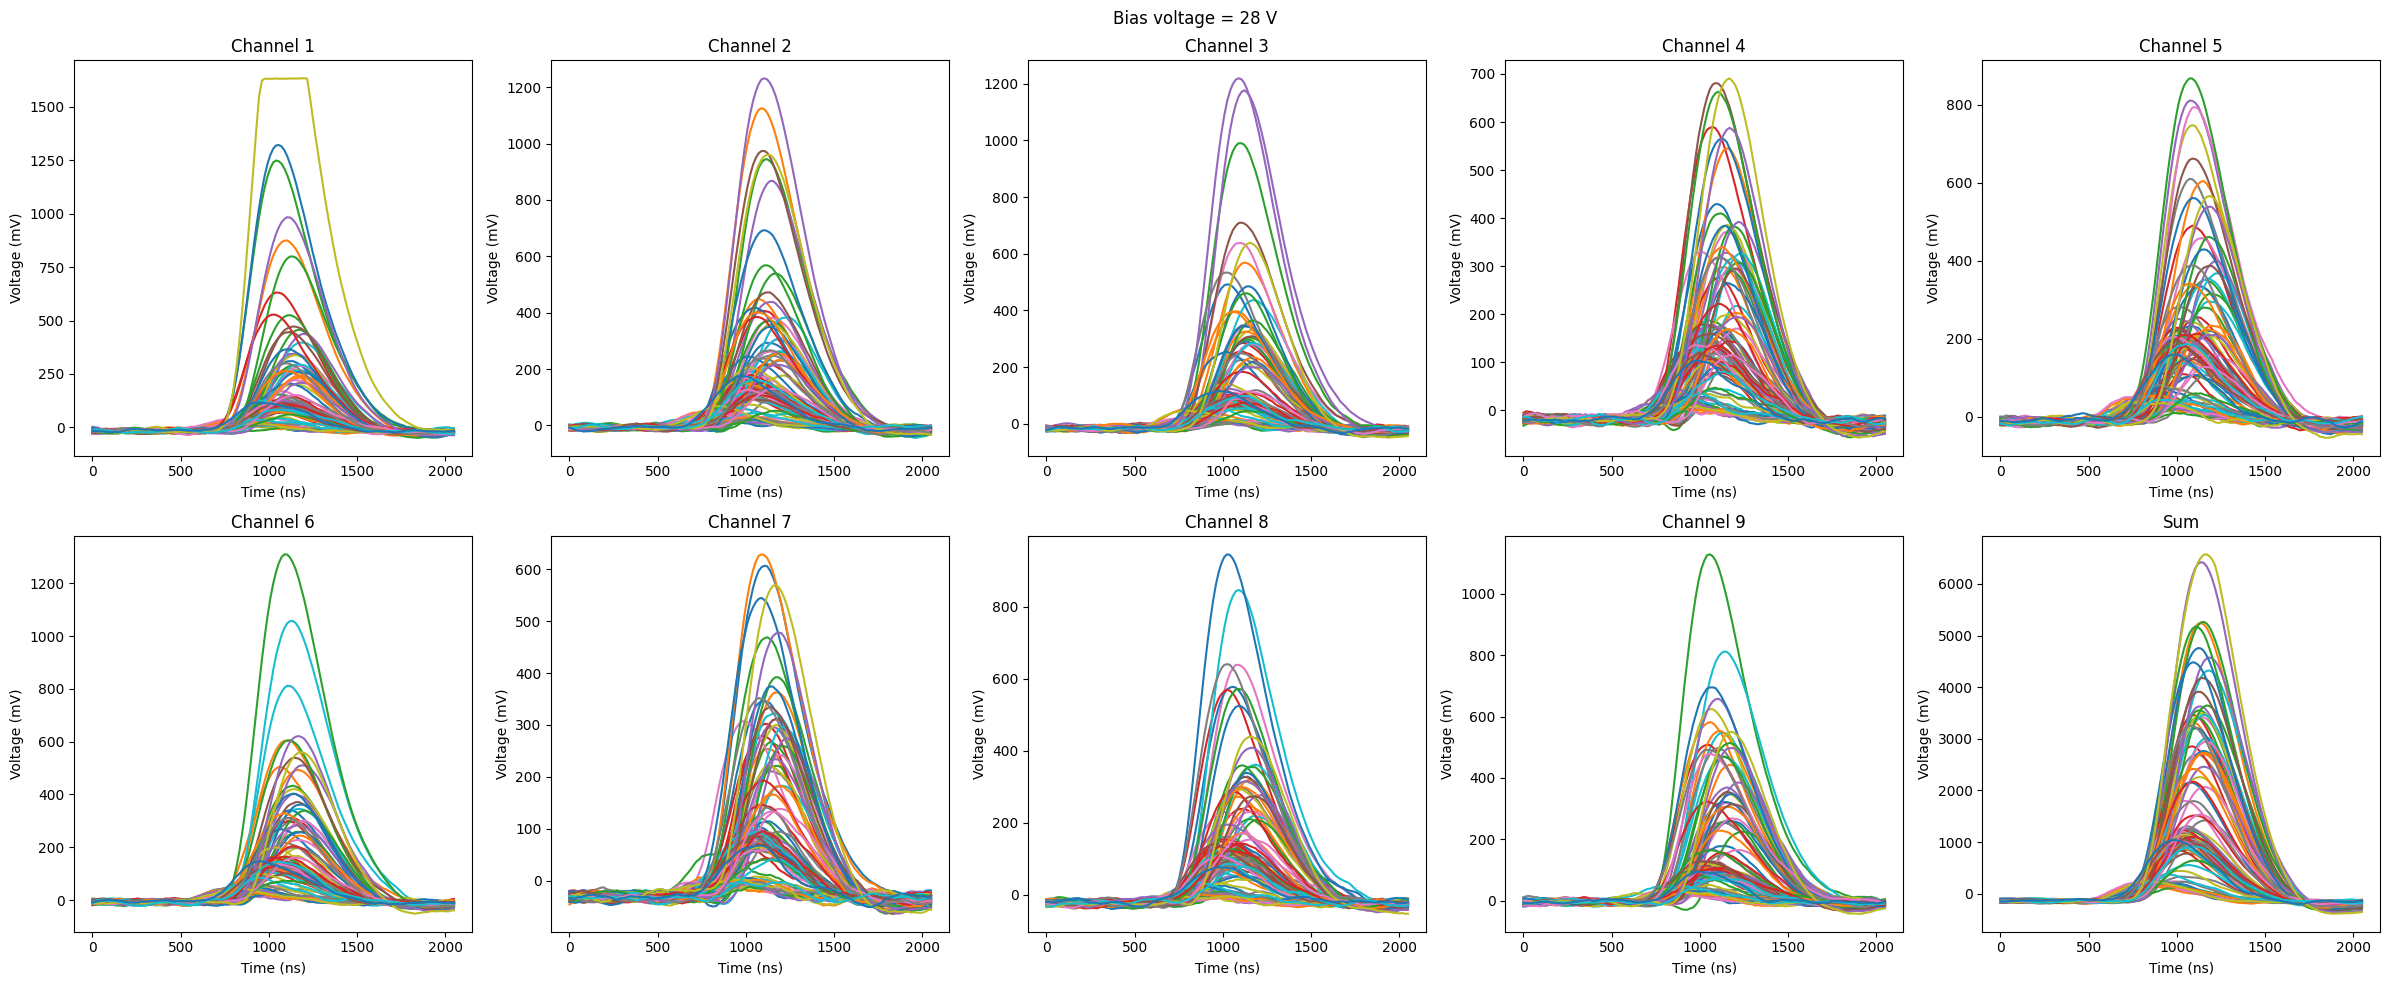

In [58]:
make_plot = True
max_figs = 100

for ov in ov_list:

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    if(nwaveforms > max_figs):
        downsamp = int(nwaveforms/max_figs)
    else:
        downsamp = 1

    if(make_plot):

        plt.figure(figsize=(24,10))

        for j in range(nwaveforms):
            if(j%downsamp != 0): continue

            for ch in range(10):
                plt.subplot(2,5,ch+1)
                plt.plot(data_dict['time'], data_dict[j][ch])
                plt.xlabel('Time (ns)')
                plt.ylabel('Voltage (mV)')
                if(ch < 9):
                    plt.title("Channel %d"%(ch+1))
                else:
                    plt.title("Sum")

        plt.suptitle("Bias voltage = %s V"%str(ov))
    plt.tight_layout()


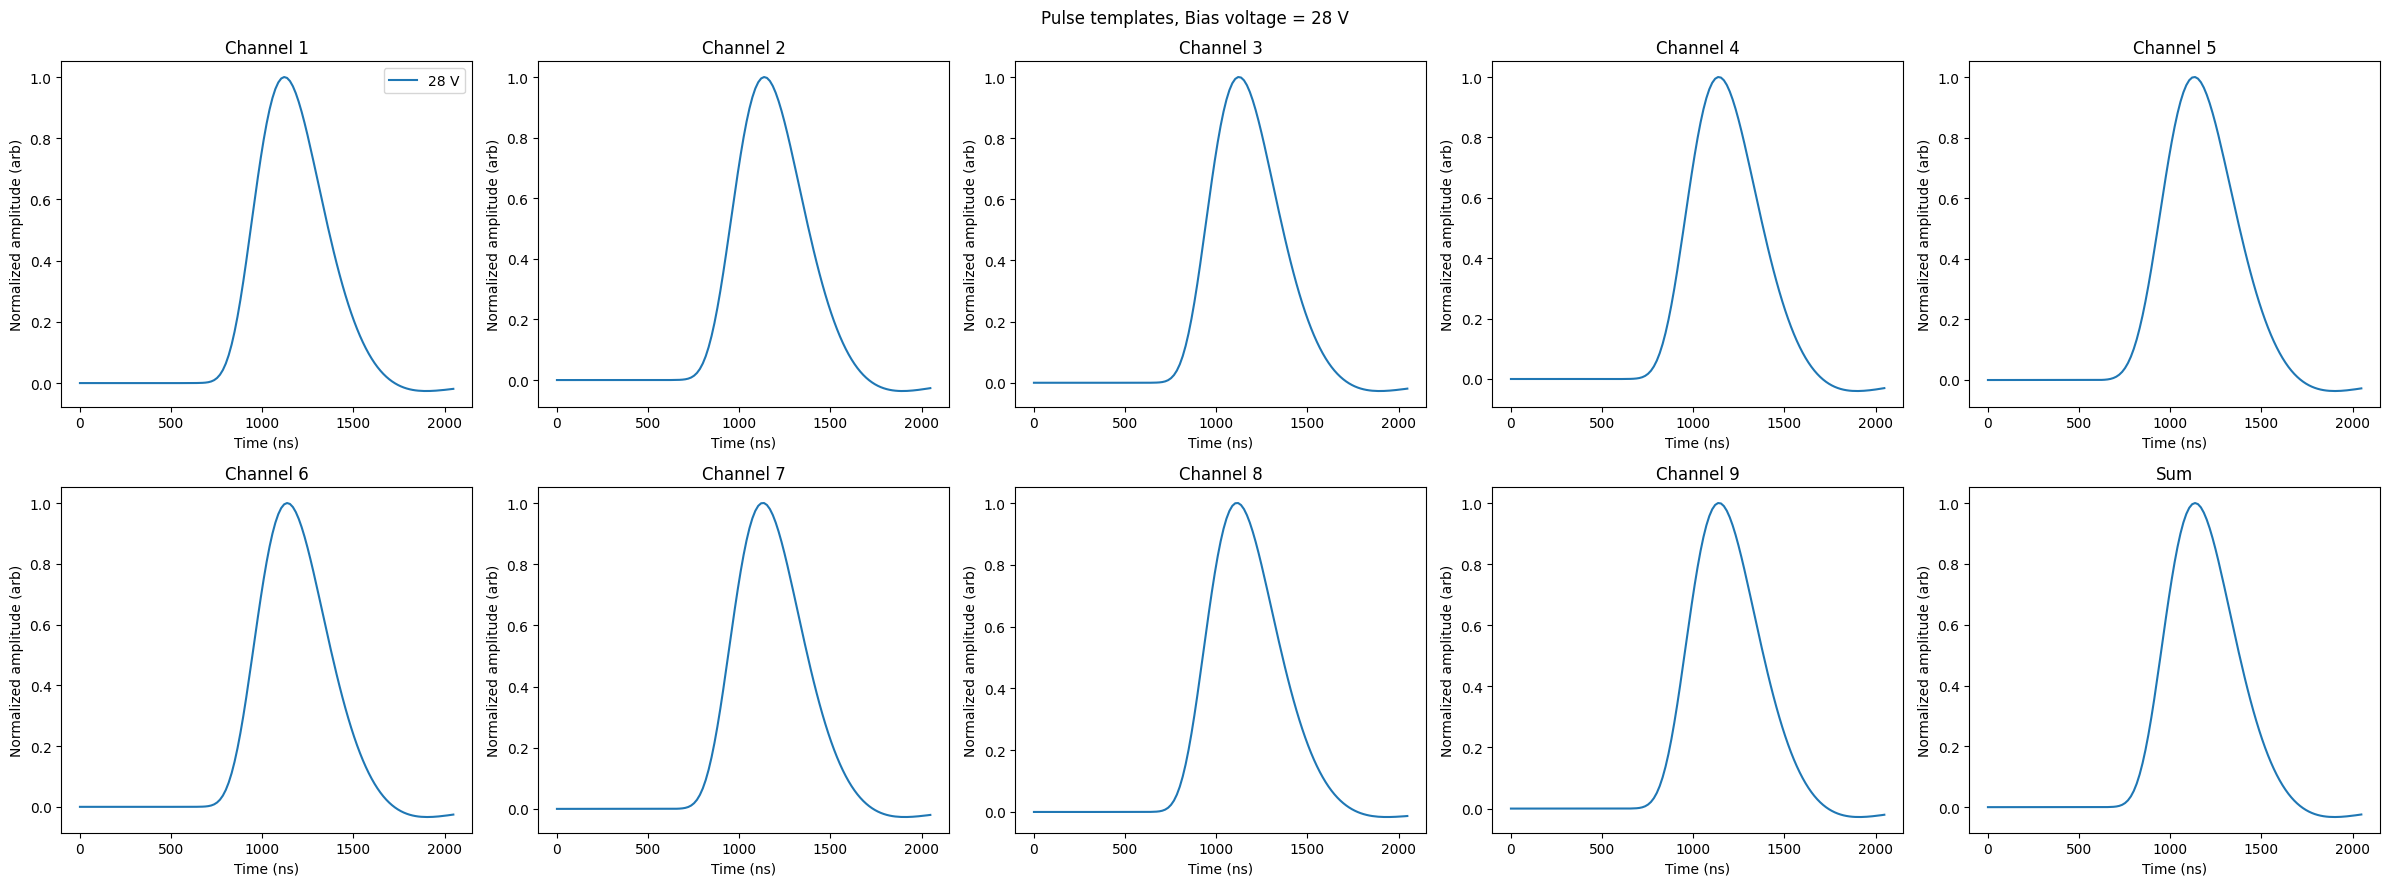

In [59]:
template_ch_dict = {}

min_vals = [200, 2000]

for ov in ov_list:

    plt.figure(figsize=(24,9))

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    ## make average template
    template_dict = {}
    nwfm = np.zeros(10)
    for ch in range(10):
        template_dict[ch] = np.zeros(len(data_dict['time']))

    for j in range(nwaveforms):

        cdat = data_dict[j]

        for ch in range(10):

            ## throw out bad traces
            min_val = min_vals[0] if ch < 9 else min_vals[1]
            if np.max(cdat[ch]) < min_val:
                continue

            template_dict[ch] += cdat[ch]
            nwfm[ch] += 1

    for ch in range(10):
        plt.subplot(2,5,ch+1)
        template_dict[ch] /= nwfm[ch]
        template_dict[ch] -= np.median(template_dict[ch][:20])
        template_dict[ch] /= np.max(template_dict[ch])

        plt.plot(data_dict['time'], template_dict[ch], label="%s V"%str(ov))
        plt.xlabel('Time (ns)')
        plt.ylabel('Normalized amplitude (arb)')

        if(ch < 9):
            plt.title("Channel %d"%(ch+1))
        else:
            plt.title("Sum")

    template_ch_dict[ov] = template_dict

    plt.suptitle("Pulse templates, Bias voltage = %s V"%str(ov))
    plt.subplot(2,5,1)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [60]:
def gauss(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [61]:
remake_files = True

tscan = 500 ## time to scan around the template in ns
pts_to_scan = int(tscan*1e-9 * fsample * 0.5)
print("scanning +/-%d points"%pts_to_scan)

for oidx, ov in enumerate(ov_list):

    if(remake_files):

        window  = [800, 1300]

        data_dict = ovs_dict[ov]['data_dict']

        mpts = (data_dict['time'] > window[0]) & (data_dict['time'] < window[1])

        recon_amps_max = []   
        recon_amps_fit = []   
          
        for k in data_dict.keys():
            if k == 'time': continue

            cdat_dict = data_dict[k]
            
            channel_max = np.zeros(10)
            channel_fit = np.zeros(10)
            for ch in range(10):

                cdat = cdat_dict[ch]

                shortened_temp = template_ch_dict[ov][ch][pts_to_scan:-pts_to_scan]

                #fit = np.sum( cdat*template_ch_dict[ov][ch] ) / np.sum(template_ch_dict[ov][ch]**2)
                fit_all = np.correlate(cdat, shortened_temp) / np.sum(shortened_temp**2)
                fit = np.max(np.abs(fit_all))

                midx = np.argmax(np.abs(cdat[mpts]))
                max_val = cdat[mpts][midx]
                
                channel_max[ch] = max_val
                channel_fit[ch] = fit
            
            recon_amps_max.append(channel_max)
            recon_amps_fit.append(channel_fit)

        recon_amps_max = np.array(recon_amps_max)
        recon_amps_fit = np.array(recon_amps_fit)

        np.savez( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)), recon_amps_max=recon_amps_max, 
                                                                                  recon_amps_fit=recon_amps_fit,
                                                                                  nwaveforms=nwaveforms)

    

scanning +/-15 points


In [62]:
def cal_fun(cal_facs, data):
    ## function to sum data multiplied by channel-by-channel calibration factors
    ## cal_facs should be row vector (1x9)
    ## data should be array (nevts x 9)
    summed_data = data @ cal_facs.T
    return np.std(summed_data)/np.median(summed_data) 

In [63]:
## optimize the channel to channel calibration

method_list = ['max', 'fit']

cal_dict_ovs = {}

for oidx, ov in enumerate(ov_list):

    cal_dict = {}
    for method in method_list:

        curr_amps = recon_amps_max if method=='max' else recon_amps_fit

        gpts = curr_amps[:,9] > 2000 ## throw out pedestal

        curr_amps = curr_amps[gpts,:9]

        cal_guess = np.ones(9)

        res = minimize(cal_fun, cal_guess, args=curr_amps, method="Nelder-Mead")

        cal_dict[method] = np.ones_like(res.x)
        print(res)

        print("Terminated successfully: ", res.success)
        print("Cal facs for %s: "%method, res.x)
    
    cal_dict_ovs[ov] = cal_dict

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.2772307772577448
             x: [ 1.092e+00  8.353e-01  1.012e+00  9.382e-01  8.720e-01
                  9.131e-01  1.129e+00  9.382e-01  1.281e+00]
           nit: 163
          nfev: 313
 final_simplex: (array([[ 1.092e+00,  8.353e-01, ...,  9.382e-01,
                         1.281e+00],
                       [ 1.092e+00,  8.353e-01, ...,  9.382e-01,
                         1.281e+00],
                       ...,
                       [ 1.092e+00,  8.353e-01, ...,  9.382e-01,
                         1.281e+00],
                       [ 1.092e+00,  8.353e-01, ...,  9.382e-01,
                         1.281e+00]]), array([ 2.772e-01,  2.772e-01,  2.772e-01,  2.772e-01,
                        2.772e-01,  2.772e-01,  2.772e-01,  2.772e-01,
                        2.772e-01,  2.772e-01]))
Terminated successfully:  True
Cal facs for max:  [1.09240852 0.83531365 1.01170179 

Cal fac:  5.517938420834658
Calib factors (keV/V):  5.113623112748321 5.517938420834658
Calib factors (keV/V):  5.113623112748321 5.517938420834658


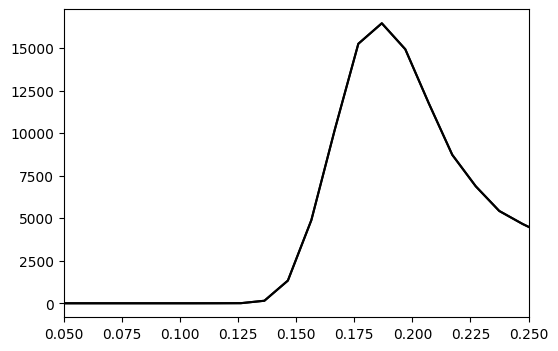

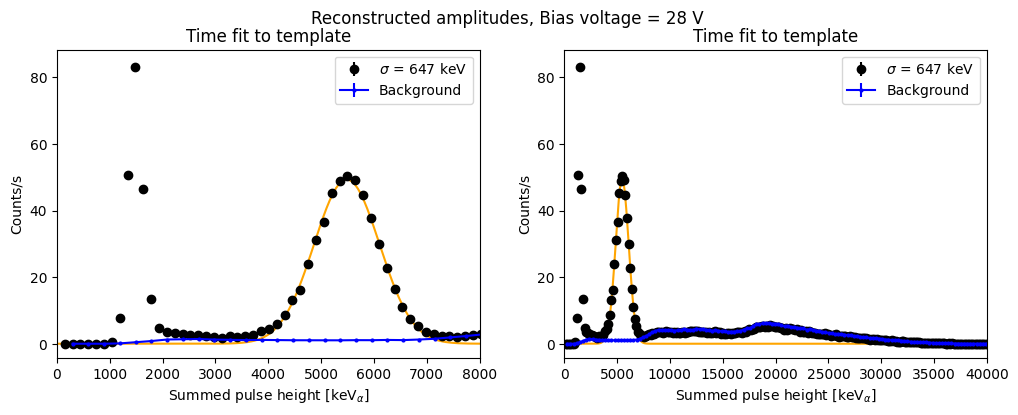

In [87]:
## plot and fit
save_str = ['Am241']
sipm_coords_x = np.array([-6.5, 0, 6.5, -6.5, 0, 6.5, -6.5, 0, 6.5])
sipm_coords_y = np.array([6.5, 6.5, 6.5, 0, 0, 0, -6.5, -6.5, -6.5])

cal_type_list = ['channel cal']

eng_fig = plt.figure(figsize=(12, 4))
z_fig = plt.figure(figsize=(6, 4))

for oidx, ov in enumerate(ov_list):

    data = np.load( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)) )
    recon_amps_max = data['recon_amps_max']
    recon_amps_fit = data['recon_amps_fit']
    nwaveforms = data['nwaveforms']



    for cal_type in cal_type_list:

        bins = np.linspace(0,14000 * (ov-24.7)/4.3, 400)
        bc = bins[:-1] + np.diff(bins)

        norm = data_time[oidx]

        if(cal_type == 'equal'):
            max_amps = recon_amps_max[:,9]
            fit_amps = recon_amps_fit[:,9]
        else:
            max_amps = recon_amps_max[:,:9] @ cal_dict_ovs[ov]['max']
            fit_amps = recon_amps_fit[:,:9] @ cal_dict_ovs[ov]['fit']

        h_max, be = np.histogram( max_amps, bins=bins )
        h_fit, be = np.histogram( fit_amps, bins=bins )

        fpts = (bc > 750) & (bc < 1250)
        errs = np.sqrt(h_max[fpts])
        errs[errs==0] = 1
        spars = [np.max(h_max), 1000, 100]
        gc_max, _ = curve_fit(gauss, bc[fpts], h_max[fpts], p0=spars, sigma=errs)
        #gc_max = spars

        errs = np.sqrt(h_fit[fpts])
        errs[errs==0] = 1
        spars = [np.max(h_fit), np.median(fit_amps), np.std(fit_amps)]
        gc_fit, _ = curve_fit(gauss, bc[fpts], h_fit[fpts], p0=spars, sigma=errs)
        #gc_fit = spars

        am241_alpha_eng = 5486 ## keV
        eng_cal_fac_max = am241_alpha_eng/np.abs(gc_max[1])
        eng_cal_fac_fit = am241_alpha_eng/np.abs(gc_fit[1])
        print("Cal fac: ", eng_cal_fac_fit)

        amps = recon_amps_fit
        recon_x = (amps[:,:9] @ sipm_coords_x.T)/np.sum(amps[:,:9], axis = 1)
        recon_y = (amps[:,:9] @ sipm_coords_y.T)/np.sum(amps[:,:9], axis = 1)
        recon_z = np.max(np.abs(amps[:,:9]), axis = 1)/np.sum(amps[:,:9], axis = 1)

        print("Calib factors (keV/V): ", eng_cal_fac_max, eng_cal_fac_fit)

        if('bkg' in str(ov)): 
            continue

        xx = np.linspace(0, bc[-1], 1000)

        plt.figure(eng_fig.number)
        plt.subplot(1,2,1)
        plt.errorbar(bc*eng_cal_fac_fit, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='ko', label=r"$\sigma$ = %.0f keV"%(gc_max[2]*eng_cal_fac_fit))
        plt.plot(xx*eng_cal_fac_fit, gauss(xx, *gc_fit)/norm, 'orange')
        plt.xlabel(r"Summed pulse height [keV$_\alpha$]")
        plt.ylabel("Counts/s")
        plt.xlim(0,8000)
        plt.title("Time fit to template")
        #plt.ylim(0,0.2)
        plt.legend()

        plt.subplot(1,2,2)
        plt.errorbar(bc*eng_cal_fac_fit, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='ko', label=r"$\sigma$ = %.0f keV"%(gc_max[2]*eng_cal_fac_fit))
        plt.plot(xx*eng_cal_fac_fit, gauss(xx, *gc_fit)/norm, 'orange')
        plt.xlabel(r"Summed pulse height [keV$_\alpha$]")
        plt.ylabel("Counts/s")
        plt.xlim(0,8000)
        plt.title("Time fit to template")
        #plt.ylim(0,0.2)
        plt.legend()

        plt.suptitle("Reconstructed amplitudes, Bias voltage = %s V"%str(ov))

        plt.figure(z_fig.number)
        zbins = np.linspace(0,1,100)
        h_z, bez = np.histogram( recon_z, bins=zbins )
        bcz = bez[:-1] + np.diff(bez)/2
        plt.plot(bcz, h_z, 'k')
        plt.xlim(0.05,0.25)


save_str = ['Bkg',]

## plot and fit

for oidx, ov in enumerate(ov_list):

    data = np.load( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)) )
    recon_amps_max = data['recon_amps_max']
    recon_amps_fit = data['recon_amps_fit']
    nwaveforms = data['nwaveforms']



    for cal_type in cal_type_list:

        bins = np.linspace(0,14000 * (ov-24.7)/4.3, 200)
        bc = bins[:-1] + np.diff(bins)

        norm = data_time[oidx]*4

        if(cal_type == 'equal'):
            max_amps = recon_amps_max[:,9]
            fit_amps = recon_amps_fit[:,9]
        else:
            max_amps = recon_amps_max[:,:9] @ cal_dict_ovs[ov]['max']
            fit_amps = recon_amps_fit[:,:9] @ cal_dict_ovs[ov]['fit']

        h_max, be = np.histogram( max_amps, bins=bins )
        h_fit, be = np.histogram( fit_amps, bins=bins )


        print("Calib factors (keV/V): ", eng_cal_fac_max, eng_cal_fac_fit)

        if('bkg' in str(ov)): 
            continue

        xx = np.linspace(0, bc[-1], 1000)

        plt.figure(eng_fig.number)
        plt.subplot(1,2,1)
        plt.errorbar(bc*eng_cal_fac_fit, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='bo-', ms=2, label=r"Background")
        plt.xlabel(r"Summed pulse height [keV$_\alpha$]")
        plt.ylabel("Counts/s")
        plt.xlim(0,8000)
        plt.title("Time fit to template")
        #plt.ylim(0,0.2)
        plt.legend()

        plt.subplot(1,2,2)
        plt.errorbar(bc*eng_cal_fac_fit, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='bo-', ms=2, label=r"Background")
        plt.xlabel(r"Summed pulse height [keV$_\alpha$]")
        plt.ylabel("Counts/s")
        plt.xlim(0,40000)
        plt.title("Time fit to template")
        #plt.ylim(0,0.2)
        plt.legend()

        plt.suptitle("Reconstructed amplitudes, Bias voltage = %s V"%str(ov))

        plt.figure(z_fig.number)
        zbins = np.linspace(0,1,100)
        h_z, bez = np.histogram( recon_z, bins=zbins )
        bcz = bez[:-1] + np.diff(bez)/2
        plt.plot(bcz, h_z, 'k')
        plt.xlim(0.05,0.25)

plt.figure(eng_fig.number)
plt.savefig(os.path.join(path, "Am241_resolution_%d.png"%ov))
plt.show()

    #plt.figure(eng_fig.number)
    #plt.savefig(os.path.join(path, "Am241_resolution_%d.png"%ov))
    #plt.show()

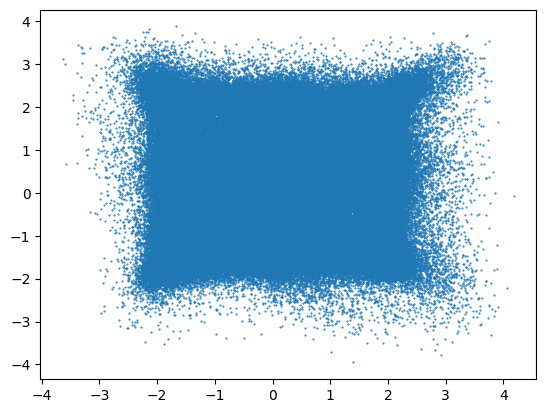

In [65]:
plt.figure()
plt.plot(recon_x, recon_y, '.', ms=1)

In [66]:
## now the background data

path = "D:/data/SiPM/waveforms/20240521/background"
filename_list = ["Bkg_28V_x0.0_y0.0_*.pkl",] 
save_str = ["Bkg",]
ov_list = [28,]
data_time = [100, ] ## acquisition time in seconds

In [67]:
remake_files = False

tscan = 500 ## time to scan around the template in ns
pts_to_scan = int(tscan*1e-9 * fsample * 0.5)
print("scanning +/-%d points"%pts_to_scan)

for oidx, ov in enumerate(ov_list):

    if(remake_files):

        window  = [800, 1300]

        data_dict = ovs_dict[ov]['data_dict']

        mpts = (data_dict['time'] > window[0]) & (data_dict['time'] < window[1])

        recon_amps_max = []   
        recon_amps_fit = []   
          
        for k in data_dict.keys():
            if k == 'time': continue

            cdat_dict = data_dict[k]
            
            channel_max = np.zeros(10)
            channel_fit = np.zeros(10)
            for ch in range(10):

                cdat = cdat_dict[ch]

                shortened_temp = template_ch_dict[ov][ch][pts_to_scan:-pts_to_scan]

                #fit = np.sum( cdat*template_ch_dict[ov][ch] ) / np.sum(template_ch_dict[ov][ch]**2)
                fit_all = np.correlate(cdat, shortened_temp) / np.sum(shortened_temp**2)
                fit = np.max(np.abs(fit_all))

                midx = np.argmax(np.abs(cdat[mpts]))
                max_val = cdat[mpts][midx]
                
                channel_max[ch] = max_val
                channel_fit[ch] = fit
            
            recon_amps_max.append(channel_max)
            recon_amps_fit.append(channel_fit)

        recon_amps_max = np.array(recon_amps_max)
        recon_amps_fit = np.array(recon_amps_fit)

        np.savez( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)), recon_amps_max=recon_amps_max, 
                                                                                  recon_amps_fit=recon_amps_fit,
                                                                                  nwaveforms=nwaveforms)

    

scanning +/-15 points


Cal fac:  1
Calib factors (keV/V):  1 1


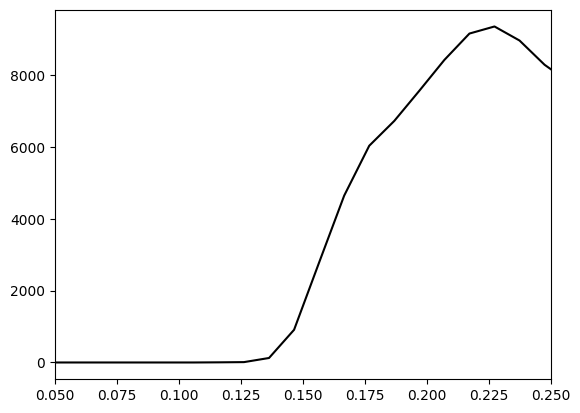

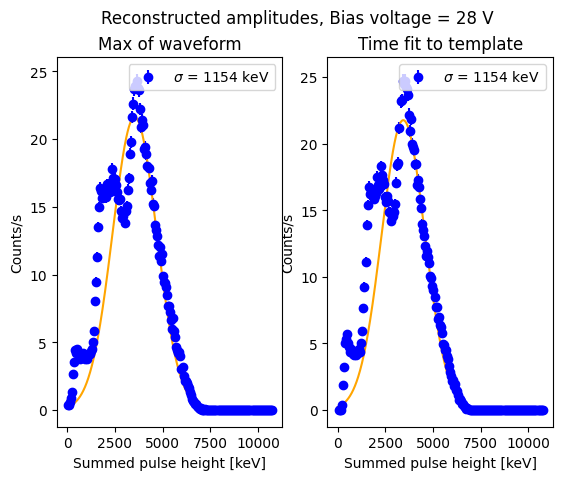

In [68]:
## plot and fit

sipm_coords_x = np.array([-6.5, 0, 6.5, -6.5, 0, 6.5, -6.5, 0, 6.5])
sipm_coords_y = np.array([6.5, 6.5, 6.5, 0, 0, 0, -6.5, -6.5, -6.5])

cal_type_list = ['channel cal']

for oidx, ov in enumerate(ov_list):

    data = np.load( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)) )
    recon_amps_max = data['recon_amps_max']
    recon_amps_fit = data['recon_amps_fit']
    nwaveforms = data['nwaveforms']



    for cal_type in cal_type_list:

        bins = np.linspace(0,14000 * (ov-24.7)/4.3, 200)
        bc = bins[:-1] + np.diff(bins)

        norm = data_time[oidx]

        if(cal_type == 'equal'):
            max_amps = recon_amps_max[:,9]
            fit_amps = recon_amps_fit[:,9]
        else:
            max_amps = recon_amps_max[:,:9] @ cal_dict_ovs[ov]['max']
            fit_amps = recon_amps_fit[:,:9] @ cal_dict_ovs[ov]['fit']

        h_max, be = np.histogram( max_amps, bins=bins )
        h_fit, be = np.histogram( fit_amps, bins=bins )

        fpts = bc > 2000
        errs = np.sqrt(h_max[fpts])
        errs[errs==0] = 1
        spars = [np.max(h_max), np.median(max_amps), np.std(max_amps)]
        gc_max, _ = curve_fit(gauss, bc[fpts], h_max[fpts], p0=spars, sigma=errs)
        #gc_max = spars

        errs = np.sqrt(h_fit[fpts])
        errs[errs==0] = 1
        spars = [np.max(h_fit), np.median(fit_amps), np.std(fit_amps)]
        gc_fit, _ = curve_fit(gauss, bc[fpts], h_fit[fpts], p0=spars, sigma=errs)
        #gc_fit = spars

        am241_alpha_eng = 5486 ## keV
        eng_cal_fac_max = 1 #am241_alpha_eng/np.abs(gc_max[1])
        eng_cal_fac_fit = 1 #am241_alpha_eng/np.abs(gc_fit[1])
        print("Cal fac: ", eng_cal_fac_fit)

        amps = recon_amps_fit
        recon_x = (amps[:,:9] @ sipm_coords_x.T)/np.sum(amps[:,:9], axis = 1)
        recon_y = (amps[:,:9] @ sipm_coords_y.T)/np.sum(amps[:,:9], axis = 1)
        recon_z = np.max(np.abs(amps[:,:9]), axis = 1)/np.sum(amps[:,:9], axis = 1)

        print("Calib factors (keV/V): ", eng_cal_fac_max, eng_cal_fac_fit)

        if('bkg' in str(ov)): 
            continue

        xx = np.linspace(0, bc[-1], 1000)

        plt.figure(eng_fig.number)
        plt.subplot(1,2,1)
        plt.errorbar(bc*eng_cal_fac_max, h_max/norm, yerr=np.sqrt(h_max)/norm, fmt='bo', label=r"$\sigma$ = %.0f keV"%(gc_max[2]*eng_cal_fac_max))
        plt.plot(xx*eng_cal_fac_max, gauss(xx, *gc_max)/norm, 'orange')
        #plt.xlim(0,8000)
        plt.xlabel("Summed pulse height [keV]")
        plt.ylabel("Counts/s")
        plt.title("Max of waveform")
        #plt.ylim(0,0.2)
        plt.legend()

        plt.subplot(1,2,2)
        plt.errorbar(bc*eng_cal_fac_fit, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='bo', label=r"$\sigma$ = %.0f keV"%(gc_max[2]*eng_cal_fac_fit))
        plt.plot(xx*eng_cal_fac_fit, gauss(xx, *gc_fit)/norm, 'orange')
        plt.xlabel("Summed pulse height [keV]")
        plt.ylabel("Counts/s")
        #plt.xlim(0,8000)
        plt.title("Time fit to template")
        #plt.ylim(0,0.2)
        plt.legend()

        plt.suptitle("Reconstructed amplitudes, Bias voltage = %s V"%str(ov))

        plt.figure(z_fig.number)
        zbins = np.linspace(0,1,100)
        h_z, bez = np.histogram( recon_z, bins=zbins )
        bcz = bez[:-1] + np.diff(bez)/2
        plt.plot(bcz, h_z, 'k')
        plt.xlim(0.05,0.25)

    plt.figure(eng_fig.number)
    plt.savefig(os.path.join(path, "Am241_resolution_%d.png"%ov))
    plt.show()